In [1]:
!pip install torchinfo

In [2]:
# import libraries
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
from torch.func import functional_call, vmap
from torch.func import functional_call
from torch.utils.data import DataLoader, Subset
from torchsummary import summary
import matplotlib.pyplot as plt
import pandas as pd
from torchinfo import summary
import matplotlib.pyplot as plt
import numpy as np
from torch.optim import optimizer



In [3]:
# some parameters
batch_size = 128
rank = 16
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [4]:
# Preparing data

# tranform functions
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,)) # standard normalization
])
transform_rotate = transforms.Compose([
    transforms.RandomRotation(60),
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,)) # standard normalization
])
transform_blur = transforms.Compose([
    transforms.GaussianBlur(3),
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,)) # standard normalization
])


# training data
# complete, 10%, 20%
train_dataset_complete = torchvision.datasets.EMNIST(root='./data', split='balanced', download=True, transform=transform)
train_dataset_10 = Subset(train_dataset_complete, range(0, len(train_dataset_complete), 10))
train_dataset_20 = Subset(train_dataset_complete, range(0, len(train_dataset_complete), 5))
print("Length of training data", len(train_dataset_complete), "\nLength of training data 10%", len(train_dataset_10), "\nLength of training data 20%", len(train_dataset_20))


# test data
test_dataset_complete = torchvision.datasets.EMNIST(root='./data', split='balanced', train=False, download=True, transform=transform)
test_dataset_rotate = torchvision.datasets.EMNIST(root='./data', split='balanced', train=False, download=True, transform=transform_rotate)
test_dataset_blur = torchvision.datasets.EMNIST(root='./data', split='balanced', train=False, download=True, transform=transform_blur)
print("Length of test data", len(test_dataset_complete))


100%|██████████| 562M/562M [00:03<00:00, 179MB/s]


Length of training data 112800 
Length of training data 10% 11280 
Length of training data 20% 22560
Length of test data 18800


### Defining Models

In [5]:
class ExecutorNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.features = nn.Sequential(
            nn.Conv2d(1, 32, 3, 1),
            nn.ReLU(),
            nn.Conv2d(32, 64, 3, 1),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Dropout(0.25),
        )
        self.classifier = nn.Sequential(
            nn.Linear(9216, 128),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(128, 47) # 47 Classes in EMNIST Balanced
        )

    def forward(self, x):
        x = self.features(x)
        x = torch.flatten(x, 1)
        x = self.classifier(x)
        return x

executor_model = ExecutorNet()
# summary = summary(executor_model, (1, 28, 28))

In [6]:
# Extract the parameters
target_shapes = {k: v.shape for k,v in executor_model.named_parameters()}

print("Parameters of Executor:")
for key, value in target_shapes.items():
    print(key,"  ||  ",value)

layer_configs = []
total_params = 0
for key, value in target_shapes.items():
  if len(value) > 1: # Matrix / Tensor
    out_d = value[0]
    in_d = value[1:].numel()
    count = (out_d * rank) + (rank * in_d)
    layer_configs.append({"name:": key, "type": "w", "shape": value, "count": count, "dims": (out_d, in_d)})
  else:
    count = value.numel()
    layer_configs.append({"name:": key, "type": "b", "shape": value, "count": count})



for layer in layer_configs:
  print(layer)
  total_params += layer["count"]

total_params_m = sum(p.numel() for p in executor_model.parameters())

print("\n--- Results ---")
print(f"Original Total Params: {total_params_m:,}")
print(f"Low-Rank Total Params: {total_params:,}")
print(f"Reduction Factor: {total_params_m / total_params:.2f}x smaller")

Parameters of Executor:
features.0.weight   ||   torch.Size([32, 1, 3, 3])
features.0.bias   ||   torch.Size([32])
features.2.weight   ||   torch.Size([64, 32, 3, 3])
features.2.bias   ||   torch.Size([64])
classifier.0.weight   ||   torch.Size([128, 9216])
classifier.0.bias   ||   torch.Size([128])
classifier.3.weight   ||   torch.Size([47, 128])
classifier.3.bias   ||   torch.Size([47])
{'name:': 'features.0.weight', 'type': 'w', 'shape': torch.Size([32, 1, 3, 3]), 'count': 656, 'dims': (32, 9)}
{'name:': 'features.0.bias', 'type': 'b', 'shape': torch.Size([32]), 'count': 32}
{'name:': 'features.2.weight', 'type': 'w', 'shape': torch.Size([64, 32, 3, 3]), 'count': 5632, 'dims': (64, 288)}
{'name:': 'features.2.bias', 'type': 'b', 'shape': torch.Size([64]), 'count': 64}
{'name:': 'classifier.0.weight', 'type': 'w', 'shape': torch.Size([128, 9216]), 'count': 149504, 'dims': (128, 9216)}
{'name:': 'classifier.0.bias', 'type': 'b', 'shape': torch.Size([128]), 'count': 128}
{'name:': 'cla

In [7]:
class SelfAdaptiveMusa(nn.Module):
    def __init__(self, ghost_model, rank=8):
        super().__init__()
        self.ghost = ghost_model
        self.rank = rank

        # 1. THE EYE (Style Encoder)
        # Looks at the input image and decides "What context is this?"
        # Output: A latent vector (size 64) that describes the image style/structure.
        self.style_encoder = nn.Sequential(
            nn.Conv2d(1, 16, 3, 2, 1), # 14x14
            nn.ReLU(),
            nn.Conv2d(16, 32, 3, 2, 1), # 7x7
            nn.ReLU(),
            nn.Flatten(),
            nn.Linear(32*7*7, 64),
            nn.Tanh() # Keep style vector bounded [-1, 1]
        )

class ModulatorNet(nn.Module):
  def __init__(self, executor_model, rank=0):
    super().__init__()
    self.executor_model = executor_model
    self.rank = rank

    # encoder to look at the input image and understand the context
    self.style_encoder = nn.Sequential(
        nn.Conv2d(1, 16, 3, 2, 1),
        nn.ReLU(),
        nn.Conv2d(16, 32, 3, 2, 1),
        nn.ReLU(),
        nn.Flatten(),
        nn.Linear(32*7*7, 64),
        nn.Tanh() # keep te styles bounded to -1 to 1
    )

    # Calculate the weights of the executor model
    self.target_shapes = {k: v.shape for k, v in executor_model.named_parameters()}
    self.layer_configs = []
    total_params = 0

    for name, shape in self.target_shapes.items():
        if len(shape) > 1: # Weight Matrix/Tensor
            out_d = shape[0]
            in_d = shape[1:].numel()
            count = (out_d * rank) + (rank * in_d)
            self.layer_configs.append({"name": name, "type": "w", "shape": shape, "dims": (out_d, in_d), "count": count})
        else: # Bias
            count = shape.numel()
            self.layer_configs.append({"name": name, "type": "b", "shape": shape, "count": count})
        total_params += count

    # generate the weights
    self.generator = nn.Sequential(
        nn.Linear(64, 128),
        nn.ReLU(),
        nn.Linear(128, total_params),
    )

  def get_weights_for_single_sample(self, style_vector):
        # 1. Get the long flat list of compressed parameters from the generator
        flat_params = self.generator(style_vector)
        weights = {}
        curr = 0

        for config in self.layer_configs:
            count = config["count"]
            # Slice the flat vector to get the chunk for this specific layer
            chunk = flat_params[curr : curr + count]
            curr += count

            if config["type"] == "w":
                # RECONSTRUCTION LOGIC:
                # We split the chunk into Matrix A and Matrix B
                out_d, in_d = config["dims"]
                size_a = out_d * self.rank

                mat_a = chunk[:size_a].view(out_d, self.rank)
                mat_b = chunk[size_a:].view(self.rank, in_d)

                # Matrix Multiplication to inflate Low Rank -> Full Rank
                # (Out x Rank) @ (Rank x In) = (Out x In)
                w = torch.matmul(mat_a, mat_b)

                weights[config["name"]] = w.view(config["shape"])
            else:
                # Biases don't need reconstruction, just reshape them
                weights[config["name"]] = chunk.view(config["shape"])

        return weights

  def forward(self, images):
      style_vectors = self.style_encoder(images)
      def executor_fwd_pass(params, single_input):
        return functional_call(self.executor_model, params, single_input.unsqueeze(0)).squeeze(0)
      batch_weights = vmap(self.get_weights_for_single_sample)(style_vectors)
      outputs = vmap(executor_fwd_pass, randomness='different')(batch_weights, images)
      return outputs

In [8]:
# define our models
executor_model = ExecutorNet()
modulator_model = ModulatorNet(executor_model, rank=rank)

# standalone model
standalone_model = ExecutorNet()

# load resnet for comparision
resnet_model = torchvision.models.resnet34(weights=None)
resnet_model.conv1 = nn.Conv2d(1, 64, kernel_size=3, stride=1, padding=1, bias=False)
resnet_model.maxpool = nn.Identity() # Delete the maxpool layer essentially
resnet_model.fc = nn.Linear(resnet_model.fc.in_features, 47)
resnet_model = resnet_model.to(device)

In [9]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

params_modulator = count_parameters(modulator_model)
params_standalone = count_parameters(standalone_model)
params_resnet = count_parameters(resnet_model)

df = pd.DataFrame([
    {"Model": "Standalone (Executor)", "Params": f"{params_standalone:,}", "Type": "Baseline"},
    {"Model": "ResNet34 (Modified)", "Params": f"{params_resnet:,}", "Type": "Industry Standard"},
    {"Model": "Modulator (Hypernet)", "Params": f"{params_modulator:,}", "Type": "Ours (Rank 16)"}
])

print("--- Parameter Comparison ---")
print(df.to_string(index=False))
print("\n" + "="*50 + "\n")

--- Parameter Comparison ---
                Model     Params              Type
Standalone (Executor)  1,204,655          Baseline
  ResNet34 (Modified) 21,299,951 Industry Standard
 Modulator (Hypernet) 21,811,518    Ours (Rank 16)




### Helper functions - Train, Eval, Plot

In [10]:
def train_modulator(train_dataset, lr, rank, batch_size, num_epoch):
    executor_model = ExecutorNet().to(device)
    modulator_model = ModulatorNet(executor_model, rank=rank).to(device)

    optimizer = torch.optim.Adam(modulator_model.parameters(), lr=lr)
    loss_fn = nn.CrossEntropyLoss()

    train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
    print("Starting training...")

    loss_history = []
    accuracy_history = []

    for epoch in range(num_epoch):

        total_loss = 0
        correct = 0
        total = 0

        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = modulator_model(images)
            loss = loss_fn(outputs, labels)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            total_loss += loss.item()
            predicted = outputs.argmax(dim=1)
            correct += (predicted == labels).sum().item()
            total += labels.size(0)

        epoch_loss = total_loss / len(train_loader)
        epoch_acc = (correct / total) * 100

        loss_history.append(epoch_loss)
        accuracy_history.append(epoch_acc)

        print(f"Epoch {epoch+1}/{num_epoch}, Loss: {epoch_loss:.4f}, Accuracy: {epoch_acc:.2f}%")

    return modulator_model, loss_history, accuracy_history

In [11]:
def train_standalone(train_dataset, lr, batch_size, num_epoch):
    standalone_model = ExecutorNet().to(device)

    optimizer = torch.optim.Adam(standalone_model.parameters(), lr=lr)
    loss_fn = nn.CrossEntropyLoss()

    train_loader = DataLoader(dataset = train_dataset, batch_size=batch_size, shuffle=True)
    print("Starting training...")

    loss_history = []
    accuracy_history = []

    for epoch in range(num_epoch):
        total_loss = 0
        correct = 0
        total = 0

        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = standalone_model(images)
            loss = loss_fn(outputs, labels)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            total_loss += loss.item()
            predicted = outputs.argmax(dim=1)
            correct += (predicted == labels).sum().item()
            total += labels.size(0)

        epoch_loss = total_loss / len(train_loader)
        epoch_acc = (correct / total) * 100

        loss_history.append(epoch_loss)
        accuracy_history.append(epoch_acc)

        print(f"Epoch {epoch+1}/{num_epoch}, Loss: {epoch_loss:.4f}, Accuracy: {epoch_acc:.2f}%")

    return standalone_model, loss_history, accuracy_history


In [12]:
def train_resnet34(train_dataset, lr, batch_size, num_epoch):
    model = torchvision.models.resnet34(weights=None)
    model.conv1 = nn.Conv2d(1, 64, kernel_size=3, stride=1, padding=1, bias=False)
    model.maxpool = nn.Identity() # Delete the maxpool layer essentially
    model.fc = nn.Linear(model.fc.in_features, 47)
    model = model.to(device)

    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    loss_fn = nn.CrossEntropyLoss()
    train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)

    print("Starting ResNet18 Training...")
    loss_history = []
    accuracy_history = []

    for epoch in range(num_epoch):
        total_loss = 0
        correct = 0
        total = 0
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = loss_fn(outputs, labels)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            total_loss += loss.item()
            predicted = outputs.argmax(dim=1)
            correct += (predicted == labels).sum().item()
            total += labels.size(0)

        epoch_loss = total_loss / len(train_loader)
        epoch_acc = (correct / total) * 100
        loss_history.append(epoch_loss)
        accuracy_history.append(epoch_acc)
        print(f"Epoch {epoch+1}, Loss: {epoch_loss:.4f}, Acc: {epoch_acc:.2f}%")

    return model, loss_history, accuracy_history

In [13]:
def plot_comparison(losses, accuracies, model_names):
    """
    losses: List of lists containing loss history for each model
    accuracies: List of lists containing accuracy history for each model
    model_names: List of strings with the names of the models
    """
    epochs = range(1, len(losses[0]) + 1)

    # Create a figure with two subplots (1 row, 2 columns)
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

    # --- Graph 1: Loss Curves ---
    for loss, name in zip(losses, model_names):
        ax1.plot(epochs, loss, label=name, marker='o', linestyle='-')

    ax1.set_title('Training Loss Comparison', fontsize=14)
    ax1.set_xlabel('Epochs')
    ax1.set_ylabel('Loss')
    ax1.legend()
    ax1.grid(True, linestyle='--', alpha=0.7)

    # --- Graph 2: Accuracy Curves ---
    for acc, name in zip(accuracies, model_names):
        ax2.plot(epochs, acc, label=name, marker='s', linestyle='-')

    ax2.set_title('Training Accuracy Comparison', fontsize=14)
    ax2.set_xlabel('Epochs')
    ax2.set_ylabel('Accuracy (%)')
    ax2.legend()
    ax2.grid(True, linestyle='--', alpha=0.7)

    plt.tight_layout()
    plt.show()

In [14]:
def evaluate_model(model, dataloader, device, model_name):
    model.eval() # Set to evaluation mode (turns off Dropout, etc.)
    loss_fn = nn.CrossEntropyLoss()

    total_loss = 0
    correct = 0
    total = 0

    print(f"Evaluating {model_name}...")

    with torch.no_grad(): # No gradients needed for eval (saves RAM)
        for images, labels in dataloader:
            images, labels = images.to(device), labels.to(device)

            outputs = model(images)
            loss = loss_fn(outputs, labels)

            total_loss += loss.item()
            predicted = outputs.argmax(dim=1)
            correct += (predicted == labels).sum().item()
            total += labels.size(0)

    avg_loss = total_loss / len(dataloader)
    avg_acc = (correct / total) * 100

    print(f"Done. Loss: {avg_loss:.4f} | Acc: {avg_acc:.2f}%")
    return avg_loss, avg_acc


In [15]:
def plot_evaluation_bars(losses, accuracies, model_names):

    # Setup
    x_pos = np.arange(len(model_names))
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

    # --- Chart 1: Test Accuracy (Higher is Better) ---
    bars1 = ax1.bar(x_pos, accuracies, color=['#3498db', '#e74c3c', '#2ecc71'], alpha=0.8)

    ax1.set_title('Final Test Accuracy (Higher is Better)', fontsize=14)
    ax1.set_xticks(x_pos)
    ax1.set_xticklabels(model_names)
    ax1.set_ylabel('Accuracy (%)')
    ax1.set_ylim(0, 100)
    ax1.grid(axis='y', linestyle='--', alpha=0.5)

    # Add numbers on top of bars
    for bar in bars1:
        height = bar.get_height()
        ax1.text(bar.get_x() + bar.get_width()/2., height,
                f'{height:.2f}%',
                ha='center', va='bottom', fontweight='bold')

    # --- Chart 2: Test Loss (Lower is Better) ---
    bars2 = ax2.bar(x_pos, losses, color=['#3498db', '#e74c3c', '#2ecc71'], alpha=0.8)

    ax2.set_title('Final Test Loss (Lower is Better)', fontsize=14)
    ax2.set_xticks(x_pos)
    ax2.set_xticklabels(model_names)
    ax2.set_ylabel('Loss')
    ax2.grid(axis='y', linestyle='--', alpha=0.5)

    # Add numbers on top of bars
    for bar in bars2:
        height = bar.get_height()
        ax2.text(bar.get_x() + bar.get_width()/2., height,
                f'{height:.4f}',
                ha='center', va='bottom', fontweight='bold')

    plt.suptitle("Model Evaluation on Unseen Test Data", fontsize=16)
    plt.tight_layout()
    plt.show()

### Standard Training

In [17]:
# parameters
train_datset = train_dataset_complete
rank = 16 # only used by our hybrid approach
lr = 0.0001
batch_size = 128
num_epoch = 10

test_loader = DataLoader(dataset=test_dataset_complete, batch_size=batch_size, shuffle=False)
test_loader_rot = DataLoader(dataset=test_dataset_rotate, batch_size=batch_size, shuffle=False)
test_loader_blur = DataLoader(dataset=test_dataset_blur, batch_size=batch_size, shuffle=False)


In [18]:
# train standalone
standalone_model, standalone_loss_history, standalone_accuracy_history = train_standalone(train_dataset=train_datset, lr=lr, batch_size=batch_size, num_epoch=num_epoch)

Starting training...
Epoch 1/10, Loss: 1.8995, Accuracy: 47.45%
Epoch 2/10, Loss: 1.0423, Accuracy: 68.38%
Epoch 3/10, Loss: 0.8430, Accuracy: 73.75%
Epoch 4/10, Loss: 0.7489, Accuracy: 76.35%
Epoch 5/10, Loss: 0.6959, Accuracy: 77.84%
Epoch 6/10, Loss: 0.6530, Accuracy: 79.05%
Epoch 7/10, Loss: 0.6277, Accuracy: 79.68%
Epoch 8/10, Loss: 0.5987, Accuracy: 80.50%
Epoch 9/10, Loss: 0.5784, Accuracy: 81.18%
Epoch 10/10, Loss: 0.5601, Accuracy: 81.74%


In [19]:
# train resnet
resnet_model, resnet_loss_history, resnet_accuracy_history = train_resnet34(train_dataset=train_datset, lr=lr, batch_size=batch_size, num_epoch=num_epoch)

Starting ResNet18 Training...
Epoch 1, Loss: 0.6608, Acc: 79.44%
Epoch 2, Loss: 0.3127, Acc: 88.40%
Epoch 3, Loss: 0.2719, Acc: 89.68%
Epoch 4, Loss: 0.2423, Acc: 90.58%
Epoch 5, Loss: 0.2182, Acc: 91.41%
Epoch 6, Loss: 0.1955, Acc: 92.12%
Epoch 7, Loss: 0.1747, Acc: 92.89%
Epoch 8, Loss: 0.1550, Acc: 93.67%
Epoch 9, Loss: 0.1359, Acc: 94.41%
Epoch 10, Loss: 0.1236, Acc: 94.93%


In [20]:
#train hybrid
modulator_model, modulator_loss_history, modulator_accuracy_history = train_modulator(train_dataset=train_datset, lr=lr, rank=rank, batch_size=batch_size, num_epoch=num_epoch)

Starting training...
Epoch 1/10, Loss: 1.2827, Accuracy: 62.91%
Epoch 2/10, Loss: 0.5971, Accuracy: 80.54%
Epoch 3/10, Loss: 0.4838, Accuracy: 83.75%
Epoch 4/10, Loss: 0.4219, Accuracy: 85.45%
Epoch 5/10, Loss: 0.3810, Accuracy: 86.51%
Epoch 6/10, Loss: 0.3482, Accuracy: 87.44%
Epoch 7/10, Loss: 0.3229, Accuracy: 88.07%
Epoch 8/10, Loss: 0.2985, Accuracy: 88.75%
Epoch 9/10, Loss: 0.2782, Accuracy: 89.42%
Epoch 10/10, Loss: 0.2635, Accuracy: 89.78%


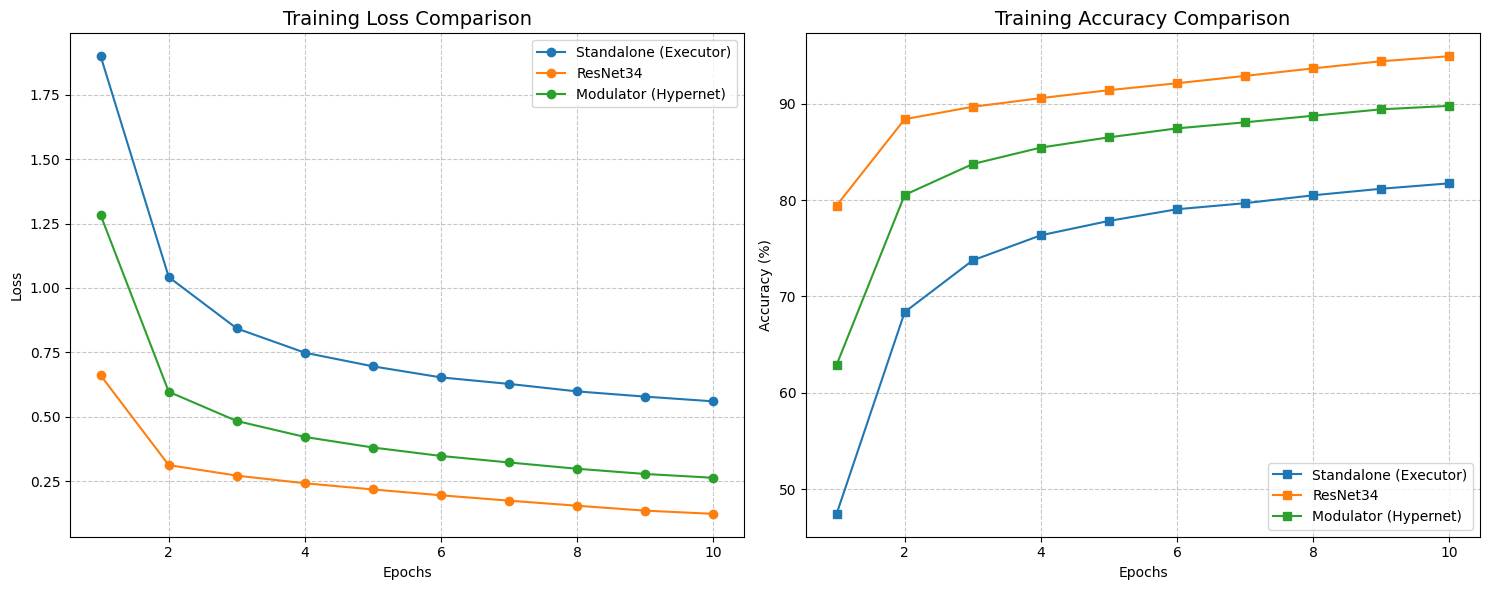

In [21]:
# collect all losses and accuracies and plot
all_losses = [standalone_loss_history, resnet_loss_history, modulator_loss_history]
all_accuracies = [standalone_accuracy_history, resnet_accuracy_history, modulator_accuracy_history]
names = ["Standalone (Executor)", "ResNet34", "Modulator (Hypernet)"]

plot_comparison(all_losses, all_accuracies, names)

Evaluating Standalone...
Done. Loss: 0.4253 | Acc: 85.64%
Evaluating ResNet34...
Done. Loss: 0.4229 | Acc: 88.10%
Evaluating Modulator...
Done. Loss: 0.4351 | Acc: 86.71%


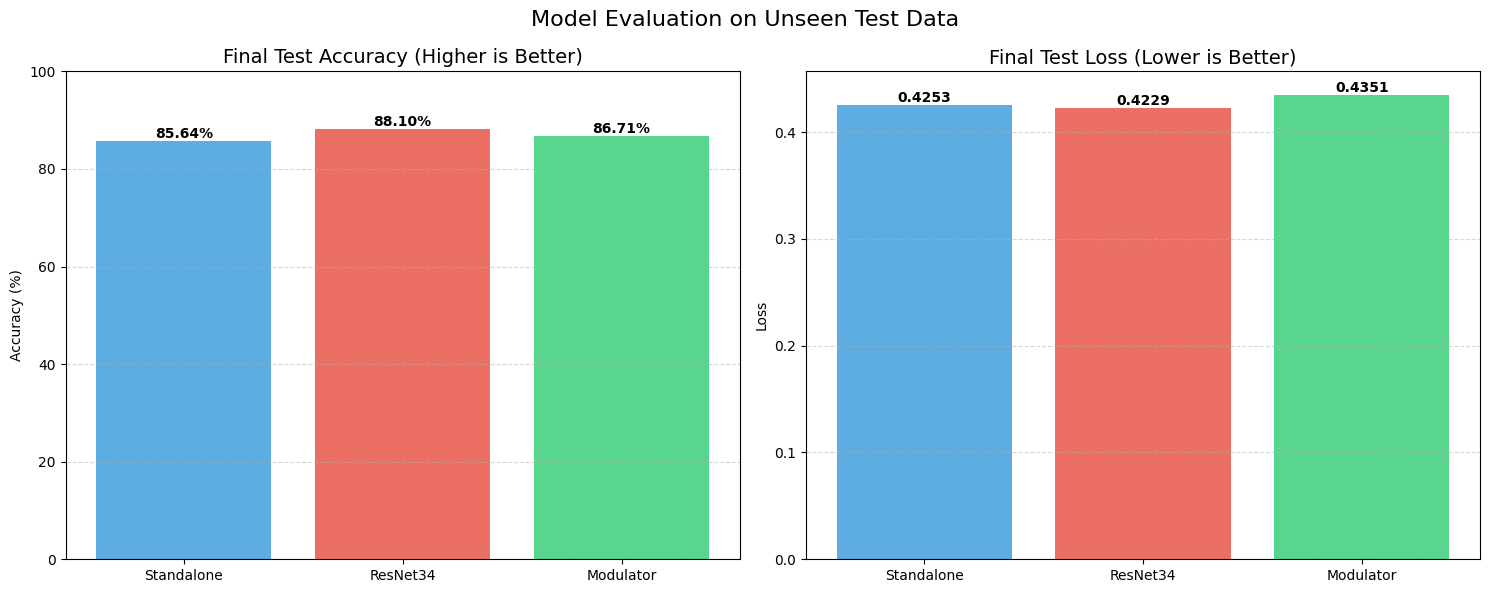

In [22]:
# test on standard test data

loss_standalone, acc_standalone = evaluate_model(standalone_model, test_loader, device, "Standalone")
loss_resnet, acc_resnet = evaluate_model(resnet_model, test_loader, device, "ResNet34")
loss_modulator, acc_modulator = evaluate_model(modulator_model, test_loader, device, "Modulator")

# Prepare Data
eval_losses = [loss_standalone, loss_resnet, loss_modulator]
eval_accs = [acc_standalone, acc_resnet, acc_modulator]
names = ["Standalone", "ResNet34", "Modulator"]

# Plot
plot_evaluation_bars(eval_losses, eval_accs, names)

Evaluating Standalone...
Done. Loss: 2.7142 | Acc: 46.22%
Evaluating ResNet34...
Done. Loss: 3.2246 | Acc: 49.29%
Evaluating Modulator...
Done. Loss: 3.8830 | Acc: 45.42%


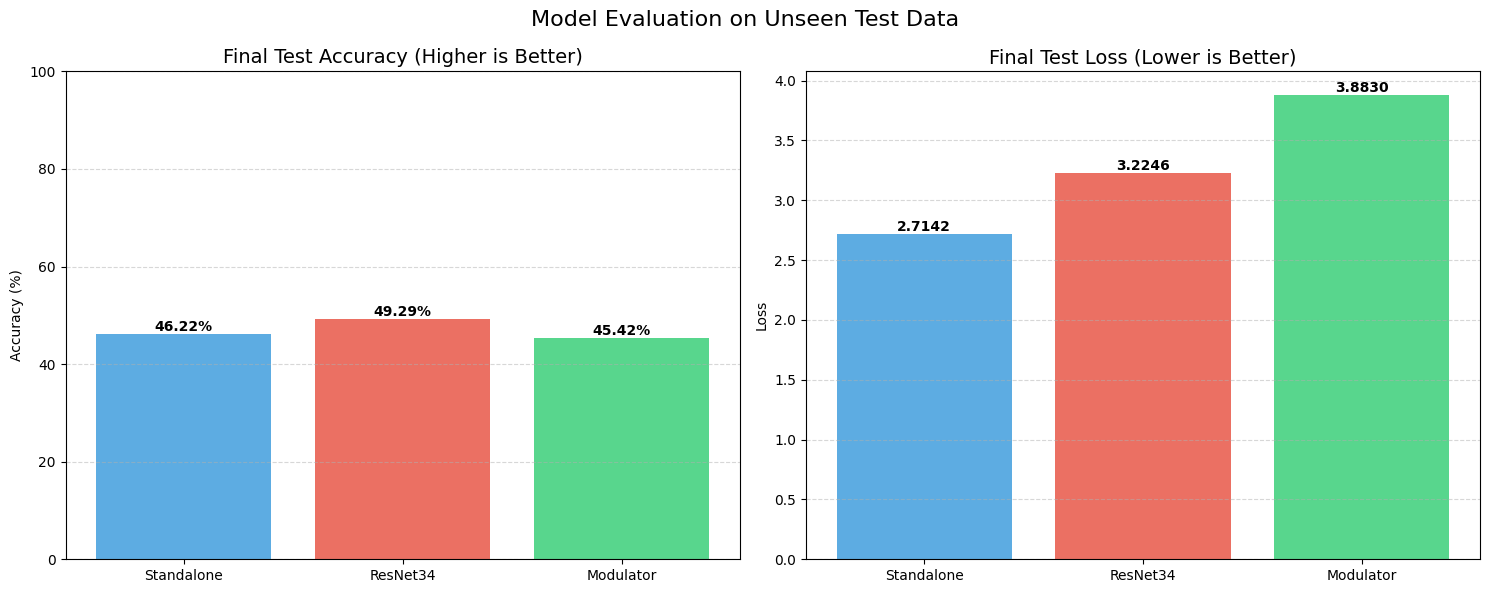

In [23]:

# test on rotated test data

loss_standalone, acc_standalone = evaluate_model(standalone_model, test_loader_rot, device, "Standalone")
loss_resnet, acc_resnet = evaluate_model(resnet_model, test_loader_rot, device, "ResNet34")
loss_modulator, acc_modulator = evaluate_model(modulator_model, test_loader_rot, device, "Modulator")

# Prepare Data
eval_losses = [loss_standalone, loss_resnet, loss_modulator]
eval_accs = [acc_standalone, acc_resnet, acc_modulator]
names = ["Standalone", "ResNet34", "Modulator"]

# Plot
plot_evaluation_bars(eval_losses, eval_accs, names)

Evaluating Standalone...
Done. Loss: 0.5055 | Acc: 83.57%
Evaluating ResNet34...
Done. Loss: 0.4742 | Acc: 87.04%
Evaluating Modulator...
Done. Loss: 0.4512 | Acc: 85.05%


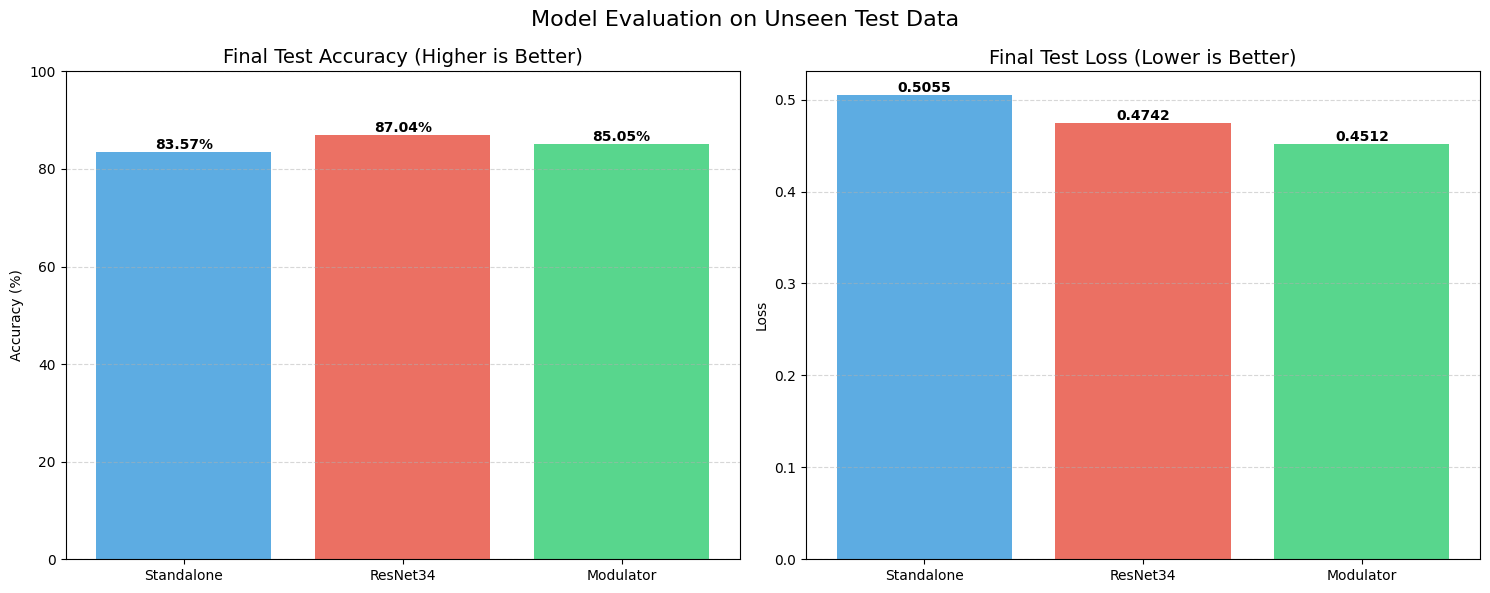

In [24]:

# test on blurred test data
loss_standalone, acc_standalone = evaluate_model(standalone_model, test_loader_blur, device, "Standalone")
loss_resnet, acc_resnet = evaluate_model(resnet_model, test_loader_blur, device, "ResNet34")
loss_modulator, acc_modulator = evaluate_model(modulator_model, test_loader_blur, device, "Modulator")

# Prepare Data
eval_losses = [loss_standalone, loss_resnet, loss_modulator]
eval_accs = [acc_standalone, acc_resnet, acc_modulator]
names = ["Standalone", "ResNet34", "Modulator"]

# Plot
plot_evaluation_bars(eval_losses, eval_accs, names)

### Train on Subset - 10%

In [27]:
# parameters
train_datset = train_dataset_10
rank = 16 # only used by our hybrid approach
lr = 0.0001
batch_size = 128
num_epoch = 5

test_loader = DataLoader(dataset=test_dataset_complete, batch_size=batch_size, shuffle=False)
test_loader_rot = DataLoader(dataset=test_dataset_rotate, batch_size=batch_size, shuffle=False)
test_loader_blur = DataLoader(dataset=test_dataset_blur, batch_size=batch_size, shuffle=False)


In [28]:
# train standalone
standalone_model, standalone_loss_history, standalone_accuracy_history = train_standalone(train_dataset=train_datset, lr=lr, batch_size=batch_size, num_epoch=num_epoch)

Starting training...
Epoch 1/5, Loss: 3.3193, Accuracy: 15.45%
Epoch 2/5, Loss: 2.4113, Accuracy: 34.65%
Epoch 3/5, Loss: 2.0751, Accuracy: 42.30%
Epoch 4/5, Loss: 1.8400, Accuracy: 47.78%
Epoch 5/5, Loss: 1.6562, Accuracy: 52.51%


In [29]:
# train resnet
resnet_model, resnet_loss_history, resnet_accuracy_history = train_resnet34(train_dataset=train_datset, lr=lr, batch_size=batch_size, num_epoch=num_epoch)

Starting ResNet18 Training...
Epoch 1, Loss: 2.5251, Acc: 35.05%
Epoch 2, Loss: 0.7348, Acc: 78.24%
Epoch 3, Loss: 0.3686, Acc: 88.31%
Epoch 4, Loss: 0.2018, Acc: 94.06%
Epoch 5, Loss: 0.1142, Acc: 96.73%


In [30]:
#train hybrid
modulator_model, modulator_loss_history, modulator_accuracy_history = train_modulator(train_dataset=train_datset, lr=lr, rank=rank, batch_size=batch_size, num_epoch=num_epoch)

Starting training...
Epoch 1/5, Loss: 3.3240, Accuracy: 14.35%
Epoch 2/5, Loss: 1.8148, Accuracy: 48.42%
Epoch 3/5, Loss: 1.2942, Accuracy: 61.56%
Epoch 4/5, Loss: 1.0491, Accuracy: 68.36%
Epoch 5/5, Loss: 0.8768, Accuracy: 72.89%


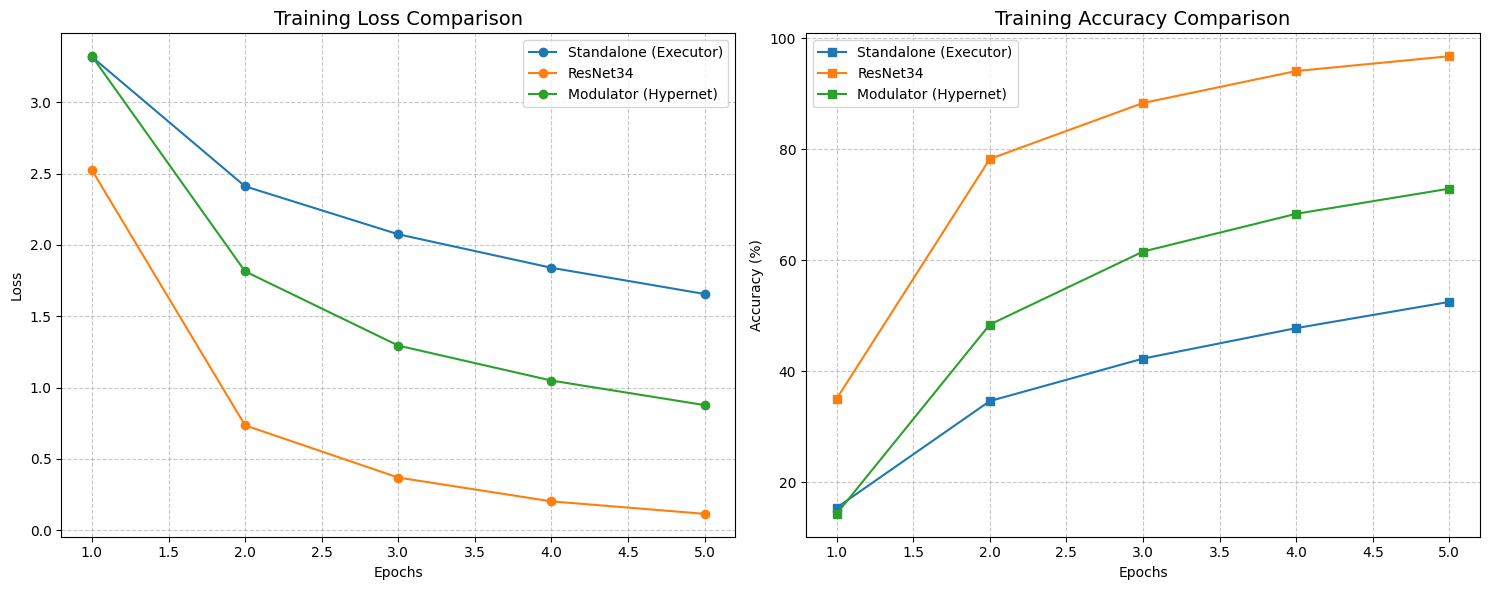

In [31]:
# collect all losses and accuracies and plot
all_losses = [standalone_loss_history, resnet_loss_history, modulator_loss_history]
all_accuracies = [standalone_accuracy_history, resnet_accuracy_history, modulator_accuracy_history]
names = ["Standalone (Executor)", "ResNet34", "Modulator (Hypernet)"]

plot_comparison(all_losses, all_accuracies, names)

Evaluating Standalone...
Done. Loss: 1.1738 | Acc: 68.37%
Evaluating ResNet34...
Done. Loss: 0.5921 | Acc: 81.91%
Evaluating Modulator...
Done. Loss: 0.9378 | Acc: 71.87%


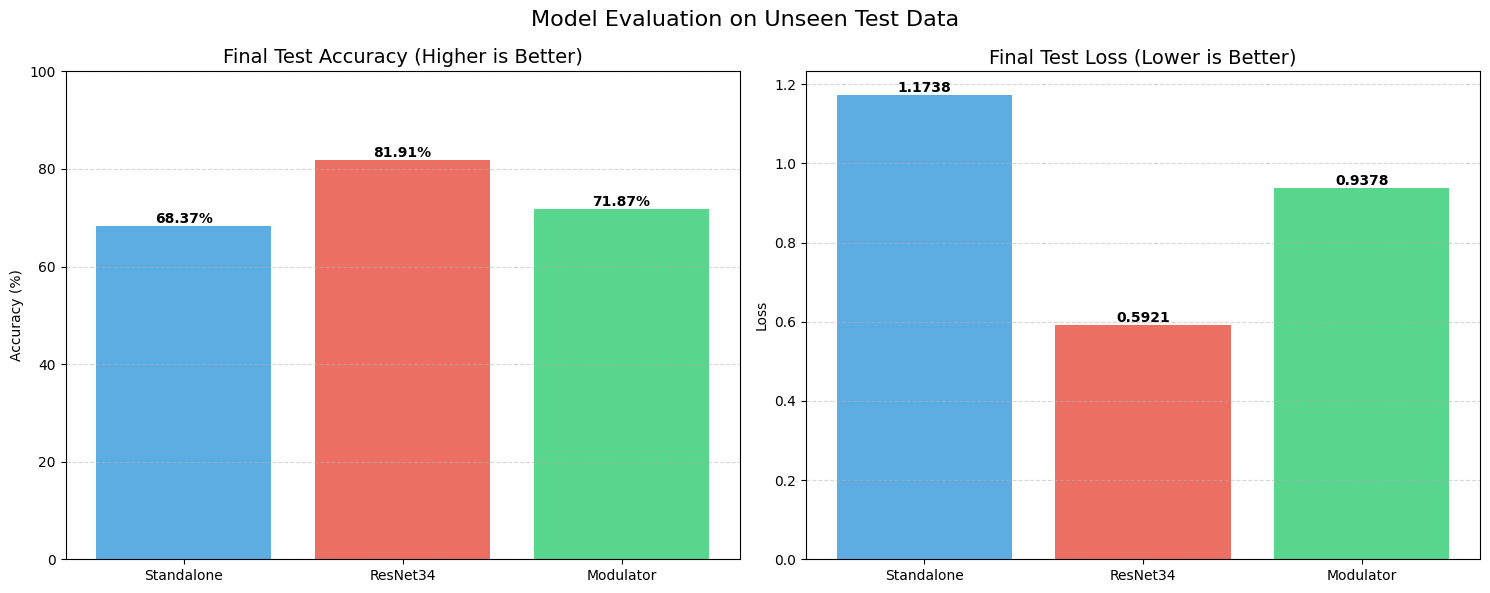

In [32]:
# test on standard test data

loss_standalone, acc_standalone = evaluate_model(standalone_model, test_loader, device, "Standalone")
loss_resnet, acc_resnet = evaluate_model(resnet_model, test_loader, device, "ResNet34")
loss_modulator, acc_modulator = evaluate_model(modulator_model, test_loader, device, "Modulator")

# Prepare Data
eval_losses = [loss_standalone, loss_resnet, loss_modulator]
eval_accs = [acc_standalone, acc_resnet, acc_modulator]
names = ["Standalone", "ResNet34", "Modulator"]

# Plot
plot_evaluation_bars(eval_losses, eval_accs, names)

Evaluating Standalone...
Done. Loss: 3.0280 | Acc: 29.22%
Evaluating ResNet34...
Done. Loss: 2.5397 | Acc: 40.06%
Evaluating Modulator...
Done. Loss: 3.3891 | Acc: 31.90%


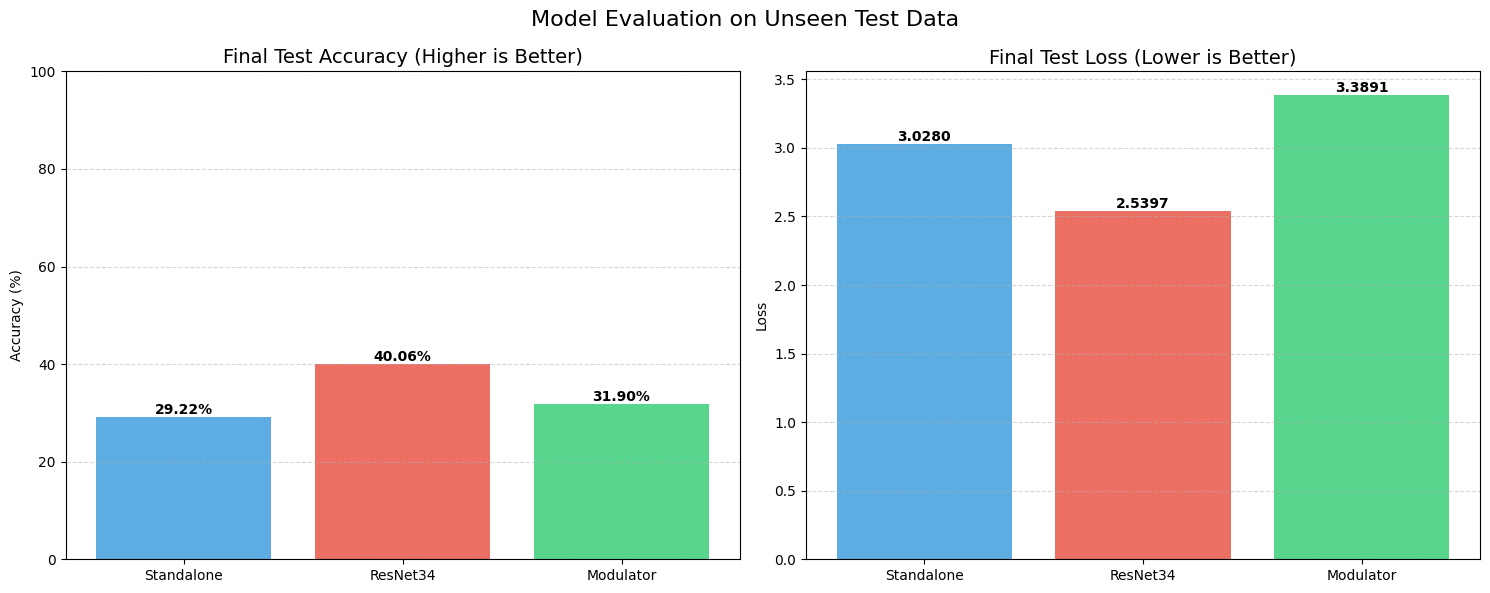

In [33]:

# test on rotated test data

loss_standalone, acc_standalone = evaluate_model(standalone_model, test_loader_rot, device, "Standalone")
loss_resnet, acc_resnet = evaluate_model(resnet_model, test_loader_rot, device, "ResNet34")
loss_modulator, acc_modulator = evaluate_model(modulator_model, test_loader_rot, device, "Modulator")

# Prepare Data
eval_losses = [loss_standalone, loss_resnet, loss_modulator]
eval_accs = [acc_standalone, acc_resnet, acc_modulator]
names = ["Standalone", "ResNet34", "Modulator"]

# Plot
plot_evaluation_bars(eval_losses, eval_accs, names)

Evaluating Standalone...
Done. Loss: 1.2908 | Acc: 67.22%
Evaluating ResNet34...
Done. Loss: 0.6730 | Acc: 79.36%
Evaluating Modulator...
Done. Loss: 1.0134 | Acc: 70.95%


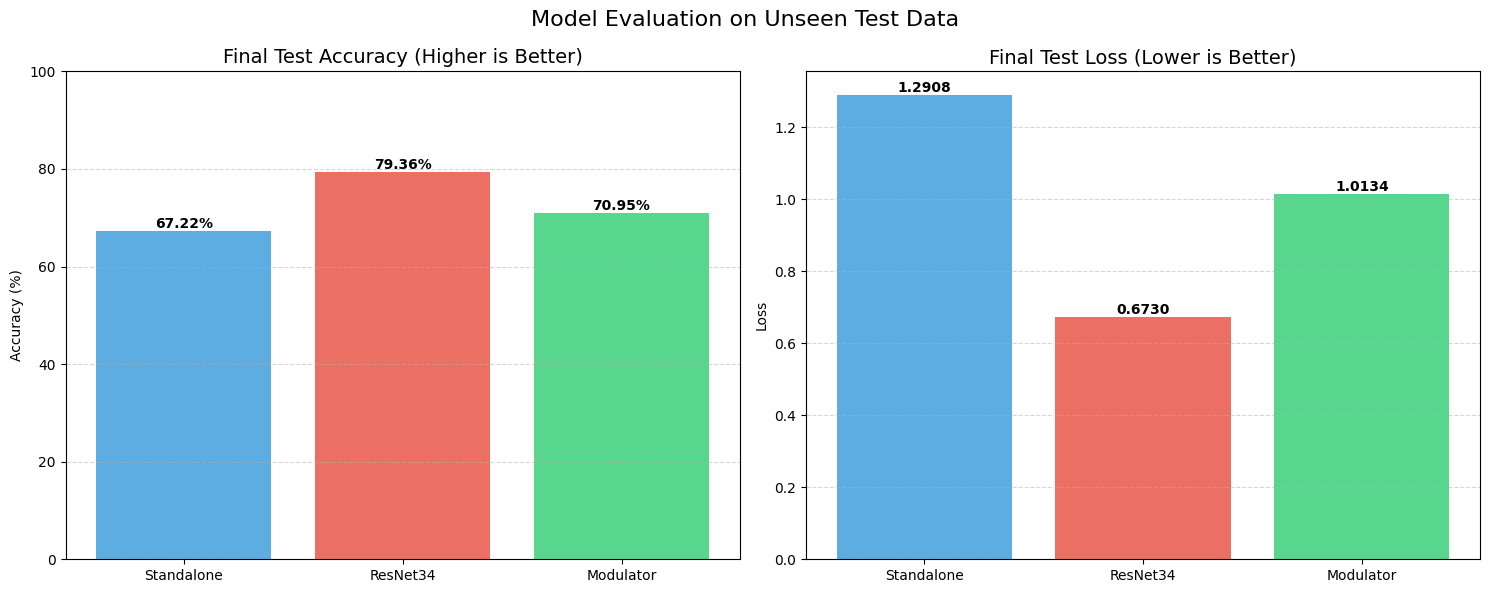

In [34]:

# test on blurred test data
loss_standalone, acc_standalone = evaluate_model(standalone_model, test_loader_blur, device, "Standalone")
loss_resnet, acc_resnet = evaluate_model(resnet_model, test_loader_blur, device, "ResNet34")
loss_modulator, acc_modulator = evaluate_model(modulator_model, test_loader_blur, device, "Modulator")

# Prepare Data
eval_losses = [loss_standalone, loss_resnet, loss_modulator]
eval_accs = [acc_standalone, acc_resnet, acc_modulator]
names = ["Standalone", "ResNet34", "Modulator"]

# Plot
plot_evaluation_bars(eval_losses, eval_accs, names)

### Train on Subset - 20%

In [36]:
# parameters
train_datset = train_dataset_20
rank = 32 # only used by our hybrid approach
lr = 0.0001
batch_size = 128
num_epoch = 5

test_loader = DataLoader(dataset=test_dataset_complete, batch_size=batch_size, shuffle=False)
test_loader_rot = DataLoader(dataset=test_dataset_rotate, batch_size=batch_size, shuffle=False)
test_loader_blur = DataLoader(dataset=test_dataset_blur, batch_size=batch_size, shuffle=False)


In [37]:
# train standalone
standalone_model, standalone_loss_history, standalone_accuracy_history = train_standalone(train_dataset=train_datset, lr=lr, batch_size=batch_size, num_epoch=num_epoch)

Starting training...
Epoch 1/5, Loss: 2.8992, Accuracy: 25.66%
Epoch 2/5, Loss: 1.9748, Accuracy: 45.76%
Epoch 3/5, Loss: 1.6287, Accuracy: 53.52%
Epoch 4/5, Loss: 1.3708, Accuracy: 60.38%
Epoch 5/5, Loss: 1.2069, Accuracy: 64.55%


In [38]:
# train resnet
resnet_model, resnet_loss_history, resnet_accuracy_history = train_resnet34(train_dataset=train_datset, lr=lr, batch_size=batch_size, num_epoch=num_epoch)

Starting ResNet18 Training...
Epoch 1, Loss: 1.6515, Acc: 56.09%
Epoch 2, Loss: 0.4589, Acc: 84.67%
Epoch 3, Loss: 0.2894, Acc: 89.90%
Epoch 4, Loss: 0.2005, Acc: 92.60%
Epoch 5, Loss: 0.1402, Acc: 95.00%


In [39]:
#train hybrid
modulator_model, modulator_loss_history, modulator_accuracy_history = train_modulator(train_dataset=train_datset, lr=lr, rank=rank, batch_size=batch_size, num_epoch=num_epoch)

Starting training...
Epoch 1/5, Loss: 2.4051, Accuracy: 35.57%
Epoch 2/5, Loss: 1.0614, Accuracy: 67.71%
Epoch 3/5, Loss: 0.7788, Accuracy: 75.23%
Epoch 4/5, Loss: 0.6315, Accuracy: 78.95%
Epoch 5/5, Loss: 0.5392, Accuracy: 81.64%


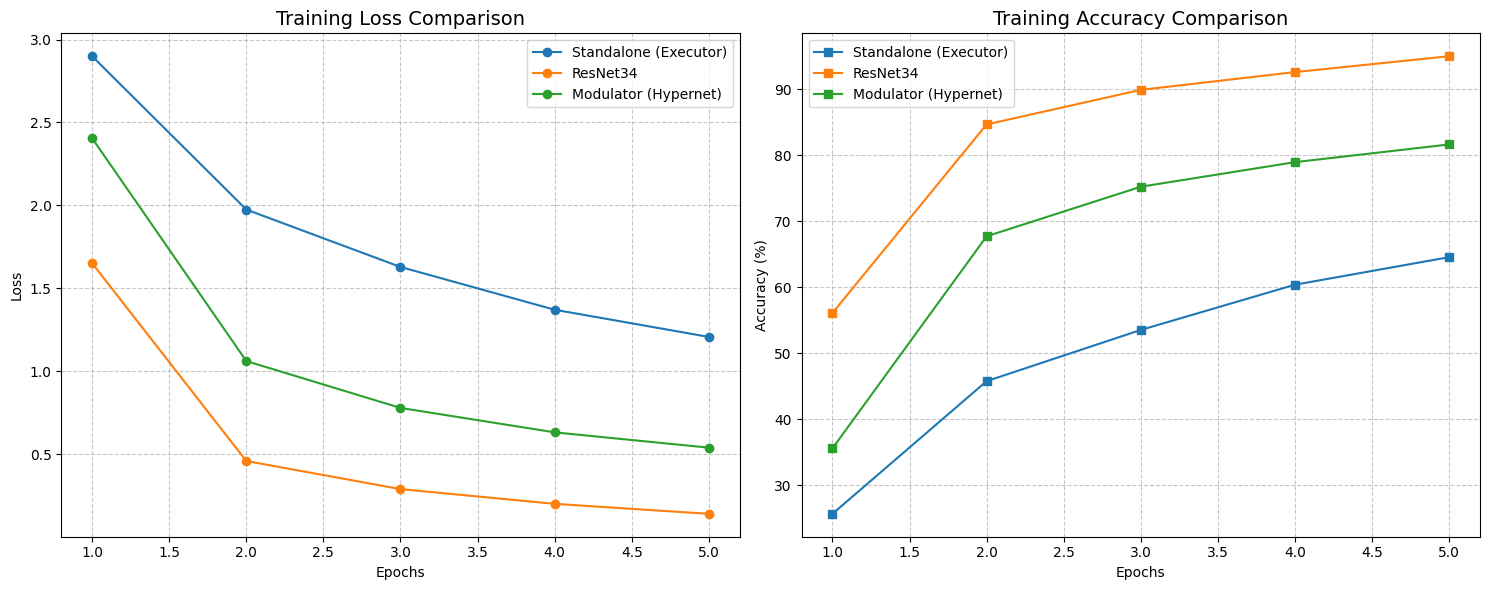

In [40]:
# collect all losses and accuracies and plot
all_losses = [standalone_loss_history, resnet_loss_history, modulator_loss_history]
all_accuracies = [standalone_accuracy_history, resnet_accuracy_history, modulator_accuracy_history]
names = ["Standalone (Executor)", "ResNet34", "Modulator (Hypernet)"]

plot_comparison(all_losses, all_accuracies, names)

Evaluating Standalone...
Done. Loss: 0.7993 | Acc: 76.89%
Evaluating ResNet34...
Done. Loss: 0.5126 | Acc: 83.62%
Evaluating Modulator...
Done. Loss: 0.5696 | Acc: 81.55%


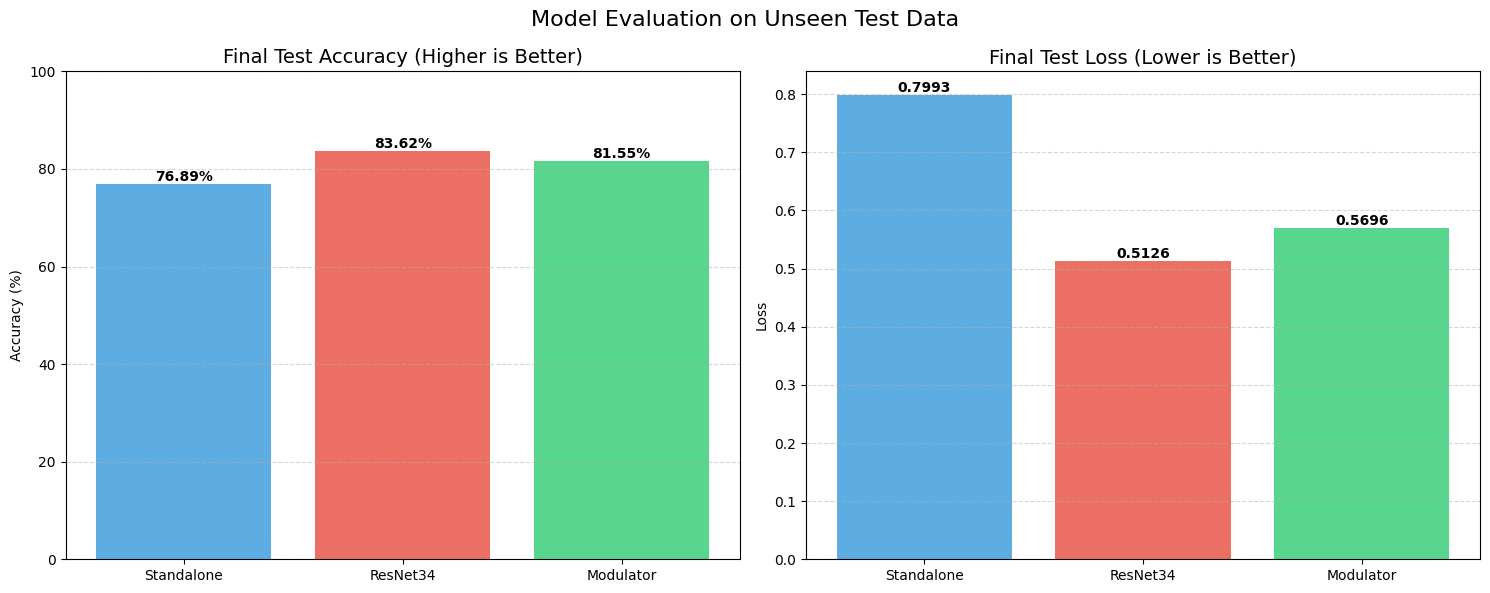

In [41]:
# test on standard test data

loss_standalone, acc_standalone = evaluate_model(standalone_model, test_loader, device, "Standalone")
loss_resnet, acc_resnet = evaluate_model(resnet_model, test_loader, device, "ResNet34")
loss_modulator, acc_modulator = evaluate_model(modulator_model, test_loader, device, "Modulator")

# Prepare Data
eval_losses = [loss_standalone, loss_resnet, loss_modulator]
eval_accs = [acc_standalone, acc_resnet, acc_modulator]
names = ["Standalone", "ResNet34", "Modulator"]

# Plot
plot_evaluation_bars(eval_losses, eval_accs, names)

Evaluating Standalone...
Done. Loss: 2.8075 | Acc: 36.13%
Evaluating ResNet34...
Done. Loss: 2.5405 | Acc: 44.56%
Evaluating Modulator...
Done. Loss: 2.7891 | Acc: 40.73%


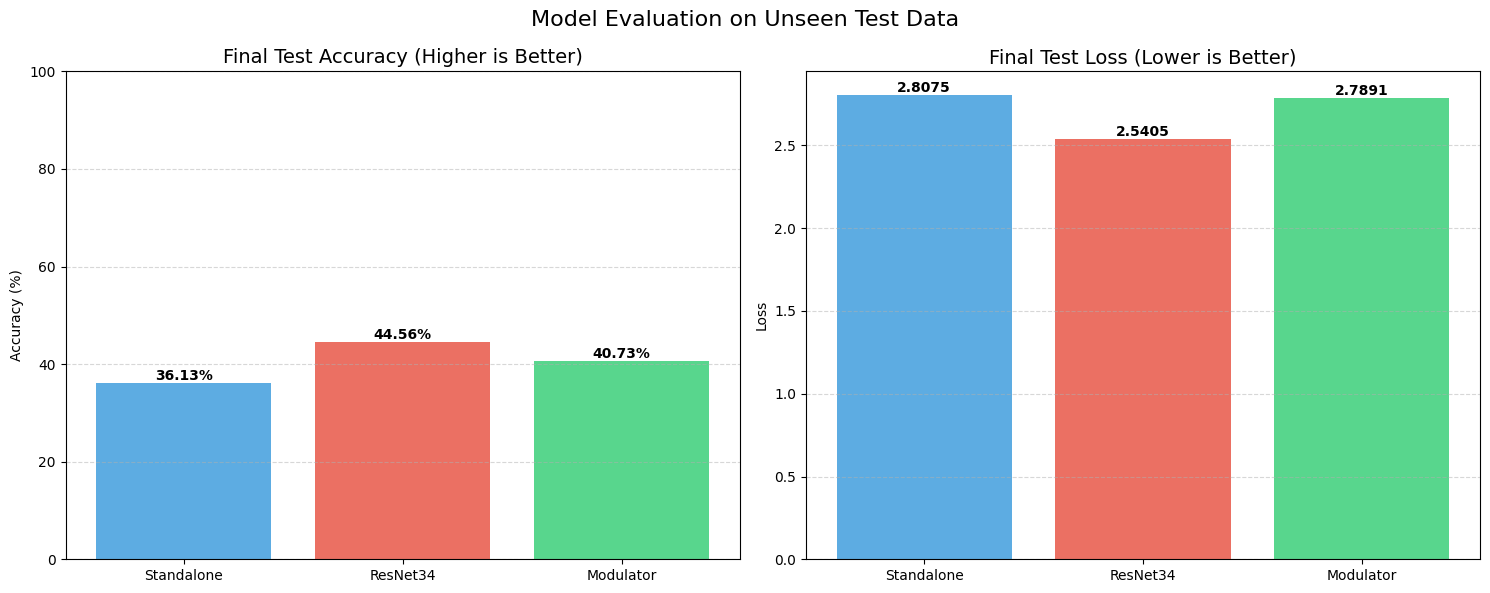

In [42]:

# test on rotated test data

loss_standalone, acc_standalone = evaluate_model(standalone_model, test_loader_rot, device, "Standalone")
loss_resnet, acc_resnet = evaluate_model(resnet_model, test_loader_rot, device, "ResNet34")
loss_modulator, acc_modulator = evaluate_model(modulator_model, test_loader_rot, device, "Modulator")

# Prepare Data
eval_losses = [loss_standalone, loss_resnet, loss_modulator]
eval_accs = [acc_standalone, acc_resnet, acc_modulator]
names = ["Standalone", "ResNet34", "Modulator"]

# Plot
plot_evaluation_bars(eval_losses, eval_accs, names)

Evaluating Standalone...
Done. Loss: 0.8964 | Acc: 76.11%
Evaluating ResNet34...
Done. Loss: 0.6044 | Acc: 80.92%
Evaluating Modulator...
Done. Loss: 0.6977 | Acc: 80.20%


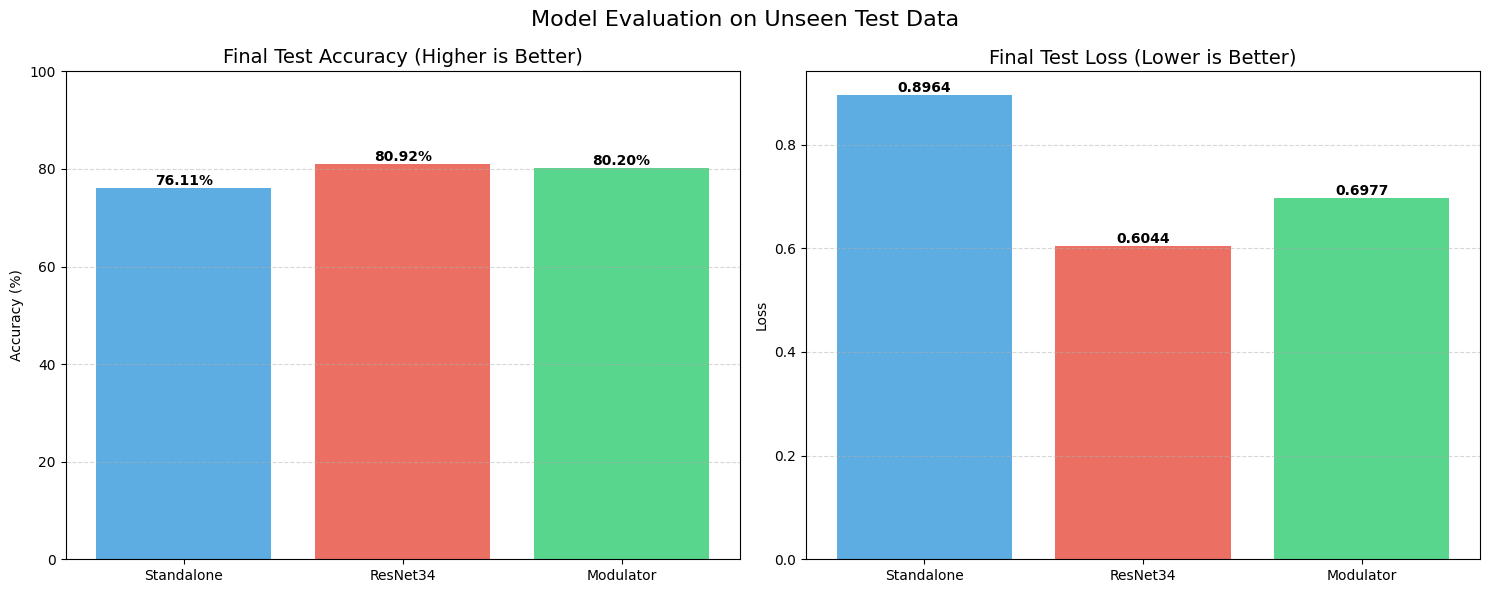

In [43]:

# test on blurred test data
loss_standalone, acc_standalone = evaluate_model(standalone_model, test_loader_blur, device, "Standalone")
loss_resnet, acc_resnet = evaluate_model(resnet_model, test_loader_blur, device, "ResNet34")
loss_modulator, acc_modulator = evaluate_model(modulator_model, test_loader_blur, device, "Modulator")

# Prepare Data
eval_losses = [loss_standalone, loss_resnet, loss_modulator]
eval_accs = [acc_standalone, acc_resnet, acc_modulator]
names = ["Standalone", "ResNet34", "Modulator"]

# Plot
plot_evaluation_bars(eval_losses, eval_accs, names)

###